In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
import warnings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingClassifier
from scipy import interp
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

pd.set_option("display.float", "{:.2f}".format)
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
np.random.seed(42)

In [3]:
# Reading the data:
df = pd.read_csv(r'C:\Users\moham\Desktop\thesis\thesis\data\data.csv')

# Getting samples from first stage only
ind = np.logical_and(df.segStageI_index > 0, df.segStageI_index <= 1) 
df = df.loc[ind, :]

# Dropping unused columns:
df = df.drop(['name', 'year', 'segStart_samp', 'segEnd_samp', 'segIndex', 'segStage', 'segStageI_index', 'segStageII_index'], axis=1)

# Dropping missing Values:
df = df.dropna()

# Target Vector:
df['pH'] = (df.pH <= 7.05).astype(int).ravel()

# Feature and target vectors:
y = df['pH'] # target
X = df.drop(['pH'], axis=1) # Feature matrix

# splitting the data into training and testing set 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

# resampling using SMOTE
sm = SMOTE(ratio=1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 

In [4]:
np.unique(y_train_res, return_counts=True)

(array([0, 1]), array([3500, 3500]))

In [5]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('feature_reduction', PCA(svd_solver='auto')),
    ('clf', LogisticRegression(n_jobs=-1, class_weight='balanced'))
]
               )



In [6]:
param_grid = {
    'feature_reduction__n_components': [5, 6, 7, 8, 9],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': 10.**np.arange(-10,0),
}




In [7]:
# grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, verbose=1, scoring='roc_auc').fit(X_train, y_train) #used the whole data
grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, verbose=1, scoring='roc_auc').fit(X_train_res, y_train_res)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.7s finished


In [8]:
print("Best parameter of (CV score = %0.3f) (AUC) :" % grid.best_score_)
print(grid.best_params_)

Best parameter of (CV score = 0.696) (AUC) :
{'clf__C': 0.1, 'clf__penalty': 'l2', 'feature_reduction__n_components': 8}


In [9]:
CVresults = pd.DataFrame(grid.cv_results_);CVresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_feature_reduction__n_components,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.13,0.03,0.00,0.00,0.00,l1,5,"{'clf__C': 1e-10, 'clf__penalty': 'l1', 'featu...",0.50,0.50,...,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.00
1,0.13,0.01,0.00,0.00,0.00,l1,6,"{'clf__C': 1e-10, 'clf__penalty': 'l1', 'featu...",0.50,0.50,...,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.00
2,0.13,0.01,0.00,0.00,0.00,l1,7,"{'clf__C': 1e-10, 'clf__penalty': 'l1', 'featu...",0.50,0.50,...,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.00
3,0.16,0.03,0.00,0.00,0.00,l1,8,"{'clf__C': 1e-10, 'clf__penalty': 'l1', 'featu...",0.50,0.50,...,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.00
4,0.19,0.02,0.00,0.00,0.00,l1,9,"{'clf__C': 1e-10, 'clf__penalty': 'l1', 'featu...",0.50,0.50,...,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.12,0.01,0.00,0.00,0.10,l2,5,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'feature...",0.62,0.64,...,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.00
96,0.15,0.03,0.00,0.00,0.10,l2,6,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'feature...",0.65,0.66,...,0.67,0.67,0.67,0.67,0.67,0.67,0.67,0.67,0.67,0.00
97,0.20,0.04,0.01,0.00,0.10,l2,7,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'feature...",0.68,0.70,...,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.00
98,0.16,0.03,0.00,0.00,0.10,l2,8,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'feature...",0.68,0.70,...,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.00


In [10]:
best_clf = grid.best_estimator_

#### Validation curve

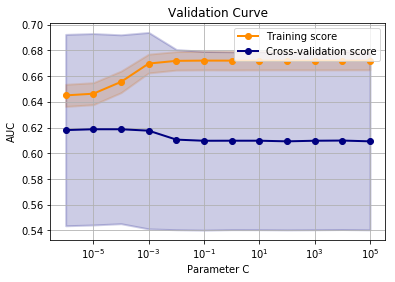

In [11]:
c_range = 10.**np.arange(-6,6)
train_scores, test_scores = validation_curve(estimator=best_clf, X=X_train, y=y_train, scoring='roc_auc', param_name='clf__C', param_range= c_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
lw = 2
plt.semilogx(c_range, train_mean, label="Training score",
             color="darkorange", lw=lw, marker='o')
plt.fill_between(c_range, train_mean - train_std,
                 train_mean + train_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(c_range, test_mean, label="Cross-validation score",
             color="navy", lw=lw, marker='o')
plt.fill_between(c_range, test_mean - test_std,
                 test_mean + test_std, alpha=0.2,
                 color="navy", lw=lw)
plt.xlabel('Parameter C')
plt.ylabel('AUC')
plt.legend(loc="best")
plt.title('Validation Curve')
plt.grid()
plt.show()



### ROC curve

In [12]:
y_proba = best_clf.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)

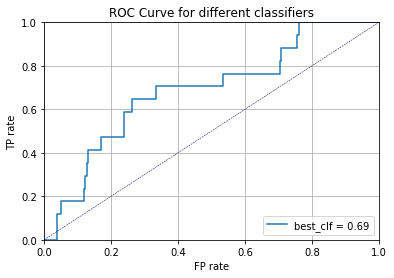

In [13]:
plt.plot(fpr, tpr, label='best_clf = %0.2f' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.legend(loc = 'lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve for different classifiers')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.grid(True)